# Continuous Control

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:

#single agent
#env = UnityEnvironment(file_name='reacher_1_agent', worker_id=0, seed=2)

# 20 agents
env = UnityEnvironment(file_name='Reacher_20_agent', worker_id=0, seed=2)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

The simulation contains `20` identical agents, each with its own copy of the environment.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
number_of_agents = len(env_info.agents)
print('Number of agents:', number_of_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.39617920e-01 -1.00000000e+00
 -7.99878311e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  8.00664425e-01]


### 3. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
def ddpg(number_of_episodes=600, time_duration=500):
    average_performance = []
    save_episodes = 50
    results_queue = deque(maxlen=100)
    results = np.zeros(number_of_agents)
    time_steps = 20
    number_of_updates = 10
    len_agents = len(str(number_of_agents))
    
    success = False
    environment_information = env.reset(train_mode=True)[brain_name]
    
    states = environment_information.vector_observations
    
    agent_parameters = {"state_size": state_size, "action_size": action_size, "random_seed": 2,}
    agents = [Agent(**agent_parameters) for _ in range(number_of_agents)]
    assert len(agents) == number_of_agents
    action = [agent.act(states[index]) for index, agent in enumerate(agents)]

    
    
    for number_of_episodes in range(1, number_of_episodes+1):
        # Retrieve the state
        states = environment_information.vector_observations                
        for agent in agents:
            agent.reset()

        for t in range(time_duration):
            #Find an action
            actions = [agent.act(states[index]) for index, agent in enumerate(agents)]
            #Get the environment
            environment_information = env.step(actions)[brain_name]
            #Get the state
            next_states = environment_information.vector_observations  
            #Get the reward      
            rewards = environment_information.rewards    
            #Find the end state                  
            completed_episodes = environment_information.local_done                     
            #Concatenate the parameters
            parameters_for_step = zip(agents, states, actions, rewards, next_states, completed_episodes)
            
            for agent, s, a, r, s_prime, d in parameters_for_step:
                agent.memory.add(s, a, r, s_prime, d)
                if ( t % time_steps == 0):
                    agent.step(number_of_updates)
            states  = next_states
            #Accumulate the rewards
            results += rewards   
            #End the episode                          
            if np.any(completed_episodes):                           
                break
                
        score = np.mean(results)        
        average_performance.append(score)
        results_queue.append(score)

        avg = np.mean(results_queue)
            
            
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f} \tMax Score: {:.2f}'.format(number_of_episodes, avg, score, np.max(results_queue)), end="\n")
        # This algorithm solves the reacher in 209 episodes, average score 30.31.
        # At episode 600 the Average score is 232.09
        if not success and np.mean(results_queue) > 30.:
            print("\r\renv __solved__ @ number_of_episodes={number_of_episodes}, w/ average_performance={avg:.2f}\r".format(number_of_episodes=number_of_episodes, avg=avg))
            success = True
        
        
        if number_of_episodes % save_episodes == 0:
            print("\repisodes: {number_of_episodes}\tavg: {avg:.2f}".format(number_of_episodes=number_of_episodes, avg=avg))

            for index, agent in enumerate(agents):
                checkPoint_actor = "actor_" + str(index).zfill(len_agents) + ".pth"
                torch.save(agent.actor_local.state_dict(), checkPoint_actor)

                checkPoint_critic = "critic_" + str(index).zfill(len_agents) + ".pth"
                torch.save(agent.critic_local.state_dict(), checkPoint_critic)

    return average_performance 

In [6]:
results = ddpg()

Episode 1	Average Score: 0.10	Score: 0.10 	Max Score: 0.10
Episode 2	Average Score: 0.26	Score: 0.41 	Max Score: 0.41
Episode 3	Average Score: 0.31	Score: 0.41 	Max Score: 0.41
Episode 4	Average Score: 0.37	Score: 0.57 	Max Score: 0.57
Episode 5	Average Score: 0.43	Score: 0.67 	Max Score: 0.67
Episode 6	Average Score: 0.47	Score: 0.67 	Max Score: 0.67
Episode 7	Average Score: 0.51	Score: 0.77 	Max Score: 0.77
Episode 8	Average Score: 0.58	Score: 1.05 	Max Score: 1.05
Episode 9	Average Score: 0.63	Score: 1.05 	Max Score: 1.05
Episode 10	Average Score: 0.68	Score: 1.16 	Max Score: 1.16
Episode 11	Average Score: 0.74	Score: 1.27 	Max Score: 1.27
Episode 12	Average Score: 0.78	Score: 1.27 	Max Score: 1.27
Episode 13	Average Score: 0.83	Score: 1.42 	Max Score: 1.42
Episode 14	Average Score: 0.88	Score: 1.54 	Max Score: 1.54
Episode 15	Average Score: 0.93	Score: 1.54 	Max Score: 1.54
Episode 16	Average Score: 0.97	Score: 1.62 	Max Score: 1.62
Episode 17	Average Score: 1.02	Score: 1.73 	Max S

Episode 135	Average Score: 11.36	Score: 21.52 	Max Score: 21.52
Episode 136	Average Score: 11.55	Score: 22.03 	Max Score: 22.03
Episode 137	Average Score: 11.73	Score: 22.42 	Max Score: 22.42
Episode 138	Average Score: 11.92	Score: 22.42 	Max Score: 22.42
Episode 139	Average Score: 12.11	Score: 22.88 	Max Score: 22.88
Episode 140	Average Score: 12.30	Score: 23.38 	Max Score: 23.38
Episode 141	Average Score: 12.50	Score: 23.38 	Max Score: 23.38
Episode 142	Average Score: 12.70	Score: 23.85 	Max Score: 23.85
Episode 143	Average Score: 12.90	Score: 24.28 	Max Score: 24.28
Episode 144	Average Score: 13.10	Score: 24.28 	Max Score: 24.28
Episode 145	Average Score: 13.30	Score: 24.63 	Max Score: 24.63
Episode 146	Average Score: 13.50	Score: 25.11 	Max Score: 25.11
Episode 147	Average Score: 13.71	Score: 25.11 	Max Score: 25.11
Episode 148	Average Score: 13.92	Score: 25.75 	Max Score: 25.75
Episode 149	Average Score: 14.13	Score: 26.24 	Max Score: 26.24
Episode 150	Average Score: 14.34	Score: 

Episode 261	Average Score: 49.80	Score: 71.78 	Max Score: 71.78
Episode 262	Average Score: 50.22	Score: 72.57 	Max Score: 72.57
Episode 263	Average Score: 50.65	Score: 73.56 	Max Score: 73.56
Episode 264	Average Score: 51.07	Score: 73.56 	Max Score: 73.56
Episode 265	Average Score: 51.51	Score: 74.63 	Max Score: 74.63
Episode 266	Average Score: 51.94	Score: 75.42 	Max Score: 75.42
Episode 267	Average Score: 52.38	Score: 75.43 	Max Score: 75.43
Episode 268	Average Score: 52.81	Score: 76.03 	Max Score: 76.03
Episode 269	Average Score: 53.25	Score: 76.59 	Max Score: 76.59
Episode 270	Average Score: 53.68	Score: 76.59 	Max Score: 76.59
Episode 271	Average Score: 54.12	Score: 77.41 	Max Score: 77.41
Episode 272	Average Score: 54.56	Score: 78.00 	Max Score: 78.00
Episode 273	Average Score: 55.00	Score: 78.01 	Max Score: 78.01
Episode 274	Average Score: 55.44	Score: 78.75 	Max Score: 78.75
Episode 275	Average Score: 55.88	Score: 79.25 	Max Score: 79.25
Episode 276	Average Score: 56.31	Score: 

Episode 386	Average Score: 111.00	Score: 136.41 	Max Score: 136.41
Episode 387	Average Score: 111.51	Score: 136.41 	Max Score: 136.41
Episode 388	Average Score: 112.03	Score: 137.25 	Max Score: 137.25
Episode 389	Average Score: 112.55	Score: 137.98 	Max Score: 137.98
Episode 390	Average Score: 113.05	Score: 137.98 	Max Score: 137.98
Episode 391	Average Score: 113.57	Score: 138.56 	Max Score: 138.56
Episode 392	Average Score: 114.09	Score: 139.41 	Max Score: 139.41
Episode 393	Average Score: 114.59	Score: 139.41 	Max Score: 139.41
Episode 394	Average Score: 115.11	Score: 140.39 	Max Score: 140.39
Episode 395	Average Score: 115.63	Score: 141.19 	Max Score: 141.19
Episode 396	Average Score: 116.15	Score: 141.19 	Max Score: 141.19
Episode 397	Average Score: 116.67	Score: 142.15 	Max Score: 142.15
Episode 398	Average Score: 117.19	Score: 142.85 	Max Score: 142.85
Episode 399	Average Score: 117.70	Score: 142.85 	Max Score: 142.85
Episode 400	Average Score: 118.22	Score: 143.55 	Max Score: 14

Episode 508	Average Score: 176.86	Score: 204.92 	Max Score: 204.92
Episode 509	Average Score: 177.43	Score: 205.99 	Max Score: 205.99
Episode 510	Average Score: 178.00	Score: 205.99 	Max Score: 205.99
Episode 511	Average Score: 178.58	Score: 206.84 	Max Score: 206.84
Episode 512	Average Score: 179.15	Score: 207.67 	Max Score: 207.67
Episode 513	Average Score: 179.72	Score: 207.67 	Max Score: 207.67
Episode 514	Average Score: 180.29	Score: 208.46 	Max Score: 208.46
Episode 515	Average Score: 180.87	Score: 209.64 	Max Score: 209.64
Episode 516	Average Score: 181.44	Score: 209.64 	Max Score: 209.64
Episode 517	Average Score: 182.02	Score: 210.64 	Max Score: 210.64
Episode 518	Average Score: 182.60	Score: 211.49 	Max Score: 211.49
Episode 519	Average Score: 183.17	Score: 211.49 	Max Score: 211.49
Episode 520	Average Score: 183.75	Score: 212.37 	Max Score: 212.37
Episode 521	Average Score: 184.33	Score: 213.26 	Max Score: 213.26
Episode 522	Average Score: 184.90	Score: 213.27 	Max Score: 21

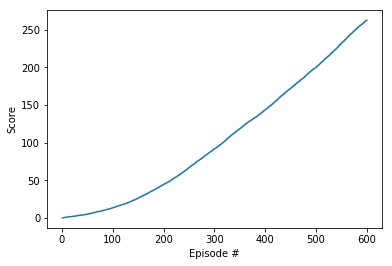

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(results)+1), results)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
env.close()